**<span style="font-size:3em;">Credit scoring</span>**


In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import calendar

from code_source.dataset import *
from code_source.exploration.plots import *
from code_source.exploration.dates import DateContainer
from code_source.features.evaluation import calculate_revenue_curve
from code_source.features.woe import WOE
import scorecardpy as sc

import statsmodels.api as sm

from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'scorecardpy'

# Problem statement 

**Objective**  
Predict customers, who will default on a loan.  
Maximaze revenue given business variables and developed predictive model.

For business model evaluation consider using the following information:  
* Loan application fee (paid only, when disbursed): 5% of Amount   
* Annual interest rate: 13%   
* When loan defaults, bank loses entire loaned amount. 


# Dataset description

In [19]:
df_original=Dataset.get_data()
df=Dataset.clean_df

In [3]:
df.columns

Index(['Customer_WID', 'DisbursementDate', 'Age', 'CustomerType', 'SOR',
       'MonthsSinceOpen', 'FinancialMeasure1', 'FinancialMeasure2',
       'FinancialMeasure3', 'FinancialMeasure4', 'CRBScore', 'Amount',
       'Default', 'AgeBin', 'CRBScoreBin', 'MonthsSinceOpenBin',
       'FinancialMeasure1Bin', 'FinancialMeasure2Bin', 'FinancialMeasure4Bin',
       'DisbursementDay', 'PreviousLoans'],
      dtype='object')

In [66]:
[q1, q3] = np.quantile(np.log(df.FinancialMeasure4+1), [0.25, 0.75])
IQR = q3 - q1
Q1_Out = q1 - 7*IQR
Q3_Out = q3 + 7*IQR
df[(np.log(df.FinancialMeasure4+1) >= Q3_Out) | (np.log(df.FinancialMeasure4+1) <= Q1_Out)]

,Customer_WID,DisbursementDate,Age,CustomerType,SOR,MonthsSinceOpen,FinancialMeasure1,FinancialMeasure2,FinancialMeasure3,FinancialMeasure4,...,Amount,Default,AgeBin,CRBScoreBin,MonthsSinceOpenBin,FinancialMeasure1Bin,FinancialMeasure2Bin,FinancialMeasure4Bin,DisbursementDay,PreviousLoans
16,228830,2017-05-27,39.0,1.0,4.0,64.0,0.0,4597.86,7805.66,0.0,...,4000.0,0,[39 - 40),[588 - 603),63.0,[0 - 13306),[4069 - 4909),[0 - 3069),27,2
40,275821,2017-05-26,57.0,1.0,4.0,137.0,0.0,2315.45,5434.76,0.0,...,3000.0,0,[53 - 58),[627 - 640),135.0,[0 - 13306),[1889 - 2328),[0 - 3069),26,1
54,67094,2017-08-09,35.0,2.0,3.0,84.0,0.0,1877.08,26533.33,0.0,...,500.0,0,[34 - 36),[476 - 511),84.0,[0 - 13306),[1490 - 1889),[0 - 3069),9,1
60,54280,2017-03-24,32.0,2.0,4.0,22.0,0.0,4614.13,12933.33,0.0,...,500.0,0,[32 - 33),[568 - 578),21.0,[0 - 13306),[4069 - 4909),[0 - 3069),24,0
237,35041,2017-01-17,31.0,2.0,7.0,101.0,0.0,154003.93,144666.66,0.0,...,2000.0,0,[31 - 32),[476 - 511),99.0,[0 - 13306),[45206 - 5705196),[0 - 3069),17,0
238,120454,2017-06-13,28.0,1.0,3.0,102.0,0.0,4.10,396.38,0.0,...,1000.0,0,[28 - 29),[603 - 614),102.0,[0 - 13306),[-4523451 - 10),[0 - 3069),13,0
259,96143,2017-09-23,30.0,1.0,4.0,39.0,0.0,15.03,7916.66,0.0,...,4950.0,1,[30 - 31),[614 - 627),39.0,[0 - 13306),[10 - 38),[0 - 3069),23,1
264,199668,2017-07-17,35.0,1.0,3.0,96.0,12750.0,199.05,366.66,0.0,...,250.0,0,[34 - 36),[664 - 675),96.0,[0 - 13306),[148 - 418),[0 - 3069),17,1
278,187550,2017-07-12,39.0,1.0,4.0,106.0,0.0,27.35,10473.00,0.0,...,3000.0,0,[39 - 40),[511 - 529),105.0,[0 - 13306),[10 - 38),[0 - 3069),12,0
315,20708,2017-03-31,28.0,1.0,4.0,55.0,0.0,10.71,5193.33,0.0,...,4850.0,0,[28 - 29),[554 - 568),54.0,[0 - 13306),[10 - 38),[0 - 3069),31,0


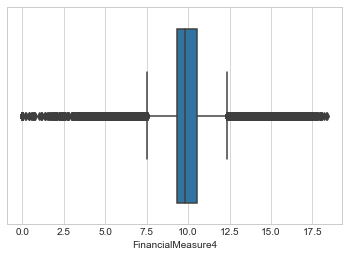

In [63]:
sns.boxplot(np.log(df.FinancialMeasure4+1))

In [24]:
df[(abs(stats.zscore(np.log(df.FinancialMeasure4+1)))>3.5) & (df.FinancialMeasure4!=0)]

,Customer_WID,DisbursementDate,Age,CustomerType,SOR,MonthsSinceOpen,FinancialMeasure1,FinancialMeasure2,FinancialMeasure3,FinancialMeasure4,...,Amount,Default,AgeBin,CRBScoreBin,MonthsSinceOpenBin,FinancialMeasure1Bin,FinancialMeasure2Bin,FinancialMeasure4Bin,DisbursementDay,PreviousLoans
1607,153662,2017-02-06,30.0,2.0,3.0,28.0,0.0,280.23,50486.37,0.73,...,11000.0,0,[30 - 31),[675 - 686),27.0,[0 - 13306),[148 - 418),[0 - 3069),6,0
2556,167133,2017-11-07,23.0,1.0,3.0,18.0,0.0,1205.73,8154.66,6.00,...,500.0,0,[18 - 25),[511 - 529),18.0,[0 - 13306),[1120 - 1490),[0 - 3069),7,0
5205,359712,2017-05-26,41.0,2.0,6.0,88.0,0.0,8664.42,91067.00,1.00,...,500.0,0,[40 - 42),[675 - 686),87.0,[0 - 13306),[7415 - 9565),[0 - 3069),26,0
8707,72458,2017-09-21,40.0,2.0,6.0,126.0,0.0,172415.83,25605862.46,27308427.00,...,40000.0,0,[40 - 42),[653 - 664),126.0,[0 - 13306),[45206 - 5705196),[269620 - 94674950),21,1
11151,121714,2017-03-15,27.0,1.0,3.0,70.0,28164.0,1180.51,7173.33,5.00,...,300.0,0,[27 - 28),[511 - 529),69.0,[27748 - 35980),[1120 - 1490),[0 - 3069),15,0
14579,31571,2017-11-14,39.0,2.0,3.0,119.0,0.0,13718.97,17503.33,10.00,...,500.0,1,[39 - 40),[588 - 603),117.0,[0 - 13306),[13177 - 20866),[0 - 3069),14,1
16111,282885,2017-05-02,31.0,2.0,5.0,83.0,0.0,23732.00,40301.66,5.00,...,200.0,0,[31 - 32),[476 - 511),81.0,[0 - 13306),[20866 - 45206),[0 - 3069),2,0
17196,3881,2017-08-12,25.0,1.0,3.0,45.0,0.0,16616.50,4668.33,5.00,...,2600.0,0,[25 - 27),[627 - 640),45.0,[0 - 13306),[13177 - 20866),[0 - 3069),12,1
17450,3608,2017-01-27,26.0,2.0,5.0,33.0,0.0,4381.84,14146.66,5.00,...,500.0,0,[25 - 27),[529 - 542),33.0,[0 - 13306),[4069 - 4909),[0 - 3069),27,0
18034,48296,2017-05-11,37.0,2.0,6.0,138.0,0.0,295879.60,36932028.64,36710730.00,...,40000.0,0,[37 - 39),[686 - 697),138.0,[0 - 13306),[45206 - 5705196),[269620 - 94674950),11,0


In [18]:
from scipy import stats


df=df[abs(stats.zscore(np.log(df.FinancialMeasure4+1)))<=3.5]

**df_original** - original dataset  
Dataset contains a sample of **one month loans**.  
Every row in the table is one loan, issued for one month. 

Row count: **{{len(df_original.index)}}**  
Column count: **{{len(df_original.columns)}}**  
**'Default'** is a dependent column that I have to to predict  

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df_original.Customer_WID.dtypes)}} |{{df_original.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df_original.DisbursementDate.dtypes)}} |{{df_original.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df_original.Age.dtypes)}} | {{df_original.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df_original.CustomerType.dtypes)}} | {{df_original.Age.isna().sum()}}|Internal customer type classification||  
| SOR | {{str(df_original.SOR.dtypes)}} | {{df_original.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df_original.MonthsSinceOpen.dtypes)}} | {{df_original.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| MonthsSinceActive | {{str(df_original.MonthsSinceActive.dtypes)}} | {{df_original.MonthsSinceActive.isna().sum()}}|Number of months since last activity || 
| FinancialMeasure1 | {{str(df_original.FinancialMeasure1.dtypes)}} |{{df_original.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df_original.FinancialMeasure2.dtypes)}} | {{df_original.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df_original.FinancialMeasure3.dtypes)}} |{{df_original.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df_original.FinancialMeasure4.dtypes)}} | {{df_original.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df_original.CRBScore.dtypes)}} | {{df_original.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df_original.Amount.dtypes)}} |{{df_original.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df_original.Default.dtypes)}} |{{df_original.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||

**df** - dataset is cleaned using following steps:
* 11 rows with NA values are removed
* column 'DisbursementDate' type is changed from object to datetime
* column 'Age' - rows are removed, where age is above 18 and below 80 
* column 'CustomerType' - rows are removed, where type is 0 or 3
* column 'MonthsSinceActive' is deleted
* column 'AgeBin' is added ('Age' binning to 5% quantile)
* column 'CRBScoreBin' is added ('CRBScore' binning to 5% quantile)
* column 'MonthsSinceOpenBin' is added ('MonthsSinceOpen' binning by 3 months)

Row count: **{{len(df.index)}}**  
Column count: **{{len(df.columns)}}**   

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df.Customer_WID.dtypes)}} |{{df.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df.DisbursementDate.dtypes)}} |{{df.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df.Age.dtypes)}} | {{df.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df.CustomerType.dtypes)}} | {{df.Age.isna().sum()}}|Internal customer type classification (1,2)||  
| SOR | {{str(df.SOR.dtypes)}} | {{df.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df.MonthsSinceOpen.dtypes)}} | {{df.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| FinancialMeasure1 | {{str(df.FinancialMeasure1.dtypes)}} |{{df.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df.FinancialMeasure2.dtypes)}} | {{df.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df.FinancialMeasure3.dtypes)}} |{{df.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df.FinancialMeasure4.dtypes)}} | {{df.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df.CRBScore.dtypes)}} | {{df.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df.Amount.dtypes)}} |{{df.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df.Default.dtypes)}} |{{df.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||
| AgeBin | {{str(df.AgeBin.dtypes)}} |{{df.AgeBin.isna().sum()}}| 'Age' binning to 5% quantile|
| CRBScoreBin | {{str(df.CRBScoreBin.dtypes)}} |{{df.CRBScoreBin.isna().sum()}}| 'CRBScore' binning to 5% quantile|
| MonthsSinceOpenBin | {{str(df.MonthsSinceOpenBin.dtypes)}} |{{df.MonthsSinceOpenBin.isna().sum()}}| 'MonthsSinceOpen' binning by 3 months|

# Data exploration 

## General loan trends

In [ ]:
tmp=df[['Age', 'CustomerType', 'SOR','CRBScore', 'Amount','Default']].iloc[:100]
g=sns.pairplot(tmp, kind='reg', hue='Default', markers=['o', 's'], palette='husl')
g.fig.suptitle('Paired scatter and regression plot',y=1.01,fontsize=24)
plt.show()

In [ ]:
corr_FM1_FM2=round(df[['FinancialMeasure3', 'FinancialMeasure4']].corr().iloc[1,0],3)
corr_CRBScore_Amount=round(df[['CRBScore', 'Amount']].corr().iloc[1,0],3)
corr_MonthsSinceOpen_Age=round(df[['MonthsSinceOpen', 'Age']].corr().iloc[1,0],3)
corr_SOR_Amount=round(df[['SOR', 'Amount']].corr().iloc[1,0],3)
tmp=df.iloc[:50,1:]
corr_matrix=tmp.corr()
heatmap(corr_matrix)

**Paired scatter and regression plot** and **Correlation plot** above shows the following facts:  
* All covariates have a small negative correlation with Default, the strongest correlation is with CRBScore (**{{corr_CRBScore_Amount}}**)
* MonthsSinceOpen correlates with age (**{{corr_MonthsSinceOpen_Age}}**), telling that there is a substantial part of long term customers with the bank  
* SOR correlates with Amount (**{{corr_SOR_Amount}}**), telling that perhaps SOR is used to set limits for a loan amount  
* FinancialMeasures correlate with Amount, telling that FinancialMeasures could be customer income or average balances  
* There is a very strong (**{{corr_FM1_FM2}}**) correlation between FinancialMeasure3 and FinancialMeasure4, which could make it more difficult to interpret regression coefficients. Perhaps we might need to use only one of them in our models.  

In [ ]:
df_original.MonthsSinceActive.value_counts(dropna=False)

In the original dataset **'MonthsSinceActive'** column has 11 'NaN' values and 1 value equals to '2', all others values are equal to '0'. It is a good indicator, it means that all customers are active. These column has been removed from **'df'** dataset because all values are the same and it will not help in prediction.

In [ ]:
tmp=df.groupby(['SOR','CustomerType'])['Customer_WID'].count().reset_index(name='LoanCount')
tmp=tmp.pivot(index='SOR',columns = 'CustomerType', values='LoanCount')
tmp.columns = ['Customer Type 1', 'Customer Type 2']
tmp['SOR'] = tmp.index
tmp.SOR = tmp.SOR.astype(np.int)
tmp = tmp.fillna(0)
stacked_barplot(data=tmp, x='SOR', y=['Customer Type 1', 'Customer Type 2'], \
        title='SOR distribution', xlabel='SOR', ylabel='Loan Count')

The majority of customers are in **'SOR'** 5.  
Distribution of customer type 1 and customer type 2 are stable.

In original dataset column **'DisbursementDate'** has type 'object', but contains date values so I made a type conversion to datetime in **'df'** dateset.  
Loan Disbursement Dates in dataset starts at **{{DateContainer.min_month}} {{DateContainer.year}}** ends at **{{DateContainer.max_month}} {{DateContainer.year}}**, a period is equal to **{{DateContainer.month_day_count.months}}** months and **{{DateContainer.month_day_count.days}}** days

In [ ]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Customer_WID']. \
        count().reset_index(name='LoanCount').sort_values('DisbursementDate')
loan_count_per_month_mean=tmp.LoanCount.mean()
loan_count_per_month_max=tmp.LoanCount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]
title='Count of loans per month'
barplot(tmp, 'DisbursementDate','LoanCount', title, 'Loan Count', 'Months')

In [ ]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Amount']. \
        sum().reset_index(name='LoanAmount').sort_values('DisbursementDate')
loan_amount_per_month_mean=tmp.LoanAmount.mean()
loan_amount_per_month_max=tmp.LoanAmount.max()
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]  
barplot(tmp, 'DisbursementDate','LoanAmount', 'Loan amount per month', 'Months', 'Loan Amount')

Mainly loan disbursement trend is stable with **{{format_number(round(loan_count_per_month_mean))}}** loans for a total value of **{{format_number(round(loan_amount_per_month_mean))}}** on average per month.   
But there appears to be a spike in March when **{{format_number(round(loan_count_per_month_max))}}** loan was issued for a total value of **{{format_number(round(loan_amount_per_month_max))}}**.

**Loan count and amount per day**  
Min loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().min()))}}**  
Max loan count in one day: **{{format_number(round(df.groupby(df_original.DisbursementDate).Customer_WID.count().max()))}}**  
Avarege loan count in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Customer_WID.count().mean()))}}**  

Min loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().min()))}}**  
Max loan amount in one day: **{{format_number(int(df.groupby(df_original.DisbursementDate).Amount.sum().max()))}}**  
Avarege loan amount in one day: **{{format_number(round(df.groupby(df.DisbursementDate).Amount.sum().mean()))}}**  

In [ ]:
tmp = df.groupby('Customer_WID')['Customer_WID'].count().reset_index(name='LoanCount').\
groupby('LoanCount').count().reset_index().rename(columns={'Customer_WID': 'CustomerCount'})
pct_repeat_customers=(tmp[tmp.LoanCount>1].CustomerCount.sum()/tmp.CustomerCount.sum())*100
title='Number of costomers by loan count (%s - %s %s)' %(DateContainer.min_month_abbr,
        DateContainer.max_month_abbr, DateContainer.year)
barplot(tmp, 'LoanCount', 'CustomerCount', title, 'Loan Count', 'Customer Count')

The chart above shows that **{{round(pct_repeat_customers,2)}}%** of customers have taken more than 1 loan in less than one year period

In [ ]:
lineplot(df_original.groupby('Age')['Customer_WID'].count(),
         'Loan count by age',
         'Customer Age',
         'Loan Count'
         )

In [ ]:
age_less18_pct=round(df_original[df_original.Age<18]['Customer_WID'].count()\
                 /df_original['Customer_WID'].count()*100,3)
age_more80_pct=round(df_original[(df_original.Age>80)&(df_original.Age<117)]['Customer_WID']\
                .count()/df_original['Customer_WID'].count()*100,3)
age_117_pct=round(df_original[df_original.Age==117]['Customer_WID'].count() \
              /df_original['Customer_WID'].count()*100,3)
age_118_count=df_original[df_original.Age==118]['Customer_WID'].count()
age_18_80=df_original[(df_original.Age>=18)&(df_original.Age<=80)]

The youngest customer is **{{int(df_original.Age.min())}}** years old  
The eldest customer is **{{int(df_original.Age.max())}}** years old  

The avarege customer age is **{{round(df_original.Age.mean())}}**.  
Age median is **{{round(df_original.Age.median())}}**.  
Age mode is **{{int(df_original.Age.mode())}}**, it means that the most customers take loans at 30 years.  
Age standard deviation is **{{round(df_original.Age.std(),3)}}**

**{{age_less18_pct}}%** customers are younger than 18 years,  in my analysis, I will suppose that loan can only be given to a person who is at least 18 years old.  
 
**{{age_more80_pct}}%** customers are between 80 years and 117 years, also {{age_118_count}} customers are 118 years old. I am not sure that this data is valid and the row count is small so I will not take thid data, when I do age binning.   

**{{age_117_pct}}%** is 117 years old. If a person born in 1900 and a loan was taken in 2017, customer can be 117 years old, but probably that is the earliest year that can be chosen and it has been put as default.  

I have removed rows where customer age is less than 18 and more than 80 in **'df'** dataset, because those rows are not trustable. Age standard deviation will be changed from **{{round(df_original.Age.std(),3)}}** to **{{round(age_18_80.Age.std(),3)}}**

In [ ]:
lineplot(df_original,
         'Average loan amount over age with confidence interval',
         'Customer Age',
         'Loan Amount',
         x='Age',
         y='Amount',
         )

The line plot with error bands showing a confidence interval. For customer between 20 and 80 years errors a much smaller, than for customer who younger than 20 or elder than 80.

In [ ]:
tmp = df_original.groupby('CustomerType').count().reset_index()
pct_loans_customer_1=(tmp[tmp.CustomerType==1.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
pct_loans_customer_2=(tmp[tmp.CustomerType==2.0].Customer_WID.sum()/tmp.Customer_WID.sum())*100
barplot(tmp, 'CustomerType', 'Customer_WID', 'Loan count by customer type', \
        'Customer Type', 'Loans', figsize=(18,6))

Internal customer type classification contains two types: '1', '2', but dataset also have 2 customers with type '3' and one customer with type '0'.  
I have deleted those 3 rows from **'df'** dataset.  
The plot above shows that **{{round(pct_loans_customer_1,2)}}%** of the loans are issued to customer type **'1'** ** and **{{round(pct_loans_customer_2,2)}}%** to customer type **'2'**.  
This leads me to believe that customer type **'1'** is a retail customer, while customer type **'2'** could be business or SME (small and medium enterprises) customer.

In [ ]:
amount_min_customer_1=df[df.CustomerType==1.0].Amount.min()
amount_max_customer_1=df[df.CustomerType==1.0].Amount.max()
amount_median_customer_1=df[df.CustomerType==1.0].Amount.median()
amount_min_customer_2=df[df.CustomerType==2.0].Amount.min()
amount_max_customer_2=df[df.CustomerType==2.0].Amount.max()
amount_median_customer_2=df[df.CustomerType==2.0].Amount.median()
densityplot(df_original[df_original.CustomerType.isin([1, 2])], 'Amount', 'CustomerType', 
        'Loan amount distribution by customer type', 
        'Loan amount', 'Density')

In [ ]:
boxplot(df, 'CustomerType', 'Amount', 'Amount of loan per Customer Type', \
        'Customer Type', 'Amount', yscale='log')

Medium amount for customer **'1'** is **{{format_number(amount_median_customer_1)}}** that is lower than median for costomer **'2'** with median **{{format_number(amount_median_customer_2)}}**.  
Customer type **'2'** distrubution is wider than customer type **'1'** distribution.  
The minimum amount is **{{format_number(amount_min_customer_2)}}**, the maximum amount is **{{format_number(int(amount_max_customer_1))}}** for customer **'1'** and **'2'**

## Default predictors

Lets start predictor exploration with **Credit Rating Bureau score** 

In [ ]:
lineplot(df, 
         'Probability of default by CBR Score', 
         'CBR Score Groups', 
         'Probability of default', 
          x='CRBScoreBin', 
          y='Default', xticks=10,percent=True
          )

In general **Credit Rating Bureau score** is predictive and the higher the score, the lower the probability of default is. But also score has bad discriminative power between **542** and **588**, where the probability of default is not monotone.

In [ ]:
lineplot(df, 
         'Probability of default by age group', 
         'Customer Age Groups', 
         'Probability of default', 
          x='AgeBin', 
          y='Default', xticks=12,percent=True
          )

Across these **age groups** probability of default varies between approximately from **1%** to **5%**.  
In general probability of default is lower in older age groups.

In [ ]:
lineplot(df, 
         'Probability of default by months since account is open', 
         'Months', 
         'Probability of default', 
          x='MonthsSinceOpenBin', 
          y='Default', xticks=12,percent=True
          )

In [ ]:
tmp = df.groupby('MonthsSinceOpen').Default.mean().reset_index(name='DefaultRate')
default_rate_more_10=tmp[tmp.DefaultRate>0.10]
default_rate_for_oldest_account=tmp.DefaultRate[tmp.MonthsSinceOpen==tmp.MonthsSinceOpen.max()].sum()
default_rate_more_10

Recently joined customers (account is opened 4 or 5 months ago) exibit considerably higher probability of default, between 15% and 24%. 
If the account is older than 2 years, the probability of default is under 5% and monotonically decreases further. 
The oldest account was opened {{int(round(tmp.MonthsSinceOpen.max()/12))}} years ago and it dafault rate is {{round(default_rate_for_oldest_account*100,2)}}%.

In [ ]:
lineplot(df, 
         'Probability of default by FinancialMeasure1', 
         'Financial Measure 1', 
         'Probability of default', 
          x='FinancialMeasure1Bin', 
          y='Default', xticks=12,percent=True
          )

In [ ]:
tmp = df.groupby('FinancialMeasure2Bin')
tmp = tmp.agg({'Default': 'mean', 'FinancialMeasure2': 'mean'})                                                                                                                            
lineplot(tmp[tmp.FinancialMeasure2<40000], 
         'Probability of default by FinancialMeasure2', 
         'Financial Measure 2', 
         'Probability of default', 
          x='FinancialMeasure2', 
          y='Default', xticks=12,percent=True, xscale='linear'
          )

In [ ]:
tmp = df.groupby('FinancialMeasure4Bin')
tmp = tmp.agg({'Default': 'mean', 'FinancialMeasure4': 'mean'})                                                                                                                            
lineplot(tmp[tmp.FinancialMeasure4<=200000], 
         'Probability of default by FinancialMeasure4', 
         'Financial Measure 4', 
         'Probability of default', 
          x='FinancialMeasure4', 
          y='Default', xticks=12,percent=True, xscale='linear'
          )

# Feature engineering 

## Outlier removal

In [ ]:
df.columns

## Feature - day of the month

One potential new feature could be day of the month, when the loan was issued.  
**'DisbursementDay'** column is added to **'df'** dateset.

In [ ]:
tmp = df.groupby('DisbursementDay').Default.mean().reset_index(name='DefaultRate')
lineplot(df, 
         'Probability of default by day of the month', 
         'Day of the month', 
         'Probability of default', 
          x='DisbursementDay', 
          y='Default', xticks=12,percent=True
          )

It appears that default rate differs significantly enough across different days to include this feature in consideration.

## Feature -  number of loans before

Another potential feature is number of loans issued previously to the same customer.  
**'PreviousLoans'** column is added to **'df'** dateset.

In [ ]:
lineplot(df, 
         'Probability of default by number of previous loans', 
         'Number of loans issued before', 
         'Probability of default', 
          x='PreviousLoans', 
          y='Default', xticks=12,percent=True
          )

Default rate goes down substantially with the number of loans customer has taken previously.

## Dataset transformation

**df** - dataset is cleaned using following steps:
* 11 rows with NA values are removed
* column 'DisbursementDate' type is changed from object to datetime
* column 'Age' - rows are removed, where age is above 18 and below 80 
* column 'CustomerType' - rows are removed, where type is 0 or 3
* column 'MonthsSinceActive' is deleted
* column 'AgeBin' is added ('Age' binning to 5% quantile)
* column 'CRBScoreBin' is added ('CRBScore' binning to 5% quantile)
* column 'MonthsSinceOpenBin' is added ('MonthsSinceOpen' binning by 3 months)
* column 'FinancialMeasure1Bin' is added ('FinancialMeasure1' binning to 5% quantile)
* column 'FinancialMeasure2Bin' is added ('FinancialMeasure2' binning to 5% quantile)
* column 'FinancialMeasure4Bin' is added ('FinancialMeasure4' binning to 5% quantile)
* column 'DisbursementDay' is added
* column 'PreviousLoans' is added

Row count: **{{len(df.index)}}**  
Column count: **{{len(df.columns)}}**   

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df.Customer_WID.dtypes)}} |{{df.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df.DisbursementDate.dtypes)}} |{{df.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  ||
| Age | {{str(df.Age.dtypes)}} | {{df.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df.CustomerType.dtypes)}} | {{df.Age.isna().sum()}}|Internal customer type classification (1,2)||  
| SOR | {{str(df.SOR.dtypes)}} | {{df.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df.MonthsSinceOpen.dtypes)}} | {{df.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| FinancialMeasure1 | {{str(df.FinancialMeasure1.dtypes)}} |{{df.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df.FinancialMeasure2.dtypes)}} | {{df.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df.FinancialMeasure3.dtypes)}} |{{df.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df.FinancialMeasure4.dtypes)}} | {{df.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df.CRBScore.dtypes)}} | {{df.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df.Amount.dtypes)}} |{{df.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df.Default.dtypes)}} |{{df.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||
| AgeBin | {{str(df.AgeBin.dtypes)}} |{{df.AgeBin.isna().sum()}}| 'Age' binning to 5% quantile|
| CRBScoreBin | {{str(df.CRBScoreBin.dtypes)}} |{{df.CRBScoreBin.isna().sum()}}| 'CRBScore' binning to 5% quantile|
| MonthsSinceOpenBin | {{str(df.MonthsSinceOpenBin.dtypes)}} |{{df.MonthsSinceOpenBin.isna().sum()}}| 'MonthsSinceOpen' binning by 3 months|
| FinancialMeasure1Bin | {{str(df.FinancialMeasure1Bin.dtypes)}} |{{df.FinancialMeasure1Bin.isna().sum()}}| 'FinancialMeasure1' binning to 5% quantile|
| FinancialMeasure2Bin | {{str(df.FinancialMeasure2Bin.dtypes)}} |{{df.FinancialMeasure2Bin.isna().sum()}}| 'FinancialMeasure2' binning to 5% quantile|
| FinancialMeasure3Bin | {{str(df.FinancialMeasure4Bin.dtypes)}} |{{df.FinancialMeasure4Bin.isna().sum()}}| 'FinancialMeasure4' binning to 5% quantile|
| DisbursementDay | {{str(df.DisbursementDay.dtypes)}} |{{df.DisbursementDay.isna().sum()}}| Day of the month, when the loan was issued|
| PreviousLoans | {{str(df.PreviousLoans.dtypes)}} |{{df.PreviousLoans.isna().sum()}}| Loans issued previously to the same customer|

In [ ]:
df[df.FinancialMeasure2Bin.isna()]

## Split dataset to test and train 
**Train/Test** split will be done in proportion of **70%/30%** and **stratified** on **'Default'** column.  
**X_train** and **X_test** contain columns {{list(X_train.columns)}}.  
**y_train** and **y_test** contain column '{{y_train.name}}'.

## Weight of evidence transformation

Weight of evidence transformation is a way to bin continuous variables and introduce non-linearity to linear or GLM model.  
It is done in two steps, first variable is split into fine classes (usually into 20-40 classes by quantiles) and then adjacent classes are merged if they have similar weight of evidence value. Weight of evidence value is calculated as 
\begin{equation*}
\mathbf{WOE} =\mathbf{\displaystyle{ln}}\Bigl(\frac{\%\ of\ non-events}{\%\ of\ events}\Bigr)
\end{equation*}

Since weight of evidence transformation of covariates is done by measuring their influence on dependent variable, this transformation should be estimated on train dataset to prevent data leakage from test dataset.  

Columns for woe transformations: 'Age', 'MonthsSinceOpen', 'FinancialMeasure1', 'FinancialMeasure2',
'FinancialMeasure4', 'CRBScore','PreviousLoans','DisbursementDay'.


In [ ]:
# df_sample = Dataset.X_train[['Age', 'MonthsSinceOpen', 'FinancialMeasure1', 'FinancialMeasure2',
#         'FinancialMeasure4', 'CRBScore','PreviousLoans','DisbursementDay']].copy()
# df_sample['Default'] = Dataset.y_train
# optimal_bin = sc.woebin(df_sample, 'Default')

In [ ]:
# x_train_woe = sc.woebin_ply(X_train, optimal_bin)
# x_test_woe = sc.woebin_ply(X_test, optimal_bin)

In [ ]:
# x_train_woe = WOE.x_train_woe
# x_test_woe = WOE.x_test_woe

In [ ]:
sc.woebin_plot(WOE.optimal_bin)
plt.show()

# Feature selection 

**List of features, which are included models:**  
* 'Age' - analysis of Age and Default interactions showed a significant negative correlation trend, older customers have lower probability of default.   
* 'CustomerType' - customer segmentation, which is important for business strategy and thus remains in the dataset. In addition average default rate for customer type 1 is lower than for customer type 2.  
* 'SOR' - measure of customer loyalty with the bank. Correlation analysis showed that this measure correlates strongly with average loan amount, but not so much with Default.  
* 'MonthsSinceOpen' - number of months with the bank. Analysis showed that the longer the customer is loyal to the bank, the lower their probability of default.  
* 'FinancialMeasure1' - financial measures of customer activity, could be balance or transactional volume. Analysis showed a significant negative correlation: with increase of financial measures probability of default goes down.  
* 'FinancialMeasure2'
* 'FinancialMeasure4'
* 'CRBScore' - primary benchmark to beat, a credit rating bureau score. The most predictive column in the dataset.  
* 'PreviousLoans' - number of previous loans, first time loan customers showed to be riskier, than repeat customers.
* 'DisbursementDay' - loan disbursement day of month. End of month days show lower probability of default.  

These features were selected based on exploratory analysis done in the prior sections. 
Variable 'FinancialMeasure3' was excluded from further modeling due to very high correlation with 'FinancialMeasure4'. 
Variable 'Amount' was excluded from modeling, bevause it is typically unknown prior to loan application.  

In addition for Logistic and Linear models, features were Weight of Evidence transformed. Random forest and Gradient boosted trees are trained using original values, because these algorithms dont benefit from such transformation. 

# Modeling 
Describe different binary classification models you used for this project. Ensure that you are correctly splitting dataset into train and test.
Model evaluation - describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.
<font color=red>
For credit scoring it is crucially important to start of with model, that is explainable and robust to outliers. Then you might want to investigate more complicated models, and provide a tradeof between explainability and predictive power.   
At the end you need to provide estimated monthly revenue by using your credit scoring model (refer to business variables above) and what is the cutoff for loan acceptance.</font>

## Linear regression model

$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon},$ where  
* $\mathbf {y}$ is a vector of observed values $\displaystyle{y}_{i} (i=1, \ldots, \displaystyle{n})$  of the variable called the dependent variable or predicted variable.  
* $\mathbf{X}$ may be seen as a matrix of row-vectors $\displaystyle{x} _{i}$ or of n-dimensional column-vectors $\displaystyle X_{j}$.  
* $\boldsymbol {\beta }$ is a $\displaystyle (p+1)$-dimensional parameter vector, where $\displaystyle \beta _{0}$ is the intercept term. Its elements are effects or regression coefficients.
* $\boldsymbol{\varepsilon}$ is a vector of values $\displaystyle\varepsilon _{i}$ is called the error term or noise.

In [ ]:
linear_model = linear_model.LinearRegression()
linear_model.fit(WOE.x_train_woe, Dataset.y_train)

In [ ]:
y_predict_lm = linear_model.predict(WOE.x_test_woe)

**$\displaystyle \beta _{0}$** - Trained model intercept: {{round(linear_model.intercept_.sum(),7)}} 

**$\displaystyle \beta _{i}$** $(i=0, \ldots, \displaystyle{9})$ -  Trained model coefficients:  
* '{{x_train_woe.columns\[0\]}}'  {{round(linear_model.coef_\[0\],7)}}
* '{{x_train_woe.columns\[1\]}}'  {{round(linear_model.coef_\[1\],7)}}
* '{{x_train_woe.columns\[2\]}}'  {{round(linear_model.coef_\[2\],7)}}
* '{{x_train_woe.columns\[3\]}}'  {{round(linear_model.coef_\[3\],7)}}
* '{{x_train_woe.columns\[4\]}}'  {{round(linear_model.coef_\[4\],7)}}
* '{{x_train_woe.columns\[5\]}}'  {{round(linear_model.coef_\[5\],7)}}
* '{{x_train_woe.columns\[6\]}}'  {{round(linear_model.coef_\[6\],7)}}
* '{{x_train_woe.columns\[7\]}}'  {{round(linear_model.coef_\[7\],7)}}
* '{{x_train_woe.columns\[8\]}}'  {{round(linear_model.coef_\[8\],7)}}
* '{{x_train_woe.columns\[9\]}}'  {{round(linear_model.coef_\[9\],7)}}

In [ ]:
kdeplot(data=y_predict_lm, title='Linear model prediction score destribution', 
        xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

## Logistic regression model

Initialize logistic regression model, training model and make predictions

In [ ]:
log_model = linear_model.LogisticRegression(solver='lbfgs',max_iter=1000)
log_model.fit(WOE.x_train_woe, Dataset.y_train)

In [ ]:
y_predict_log = log_model.predict_proba(WOE.x_test_woe)[:,1]

**$\displaystyle \beta _{0}$** - Trained model intercept: {{round(log_model.intercept_.sum(),7)}} 

**$\displaystyle \beta _{i}$** $(i=0, \ldots, \displaystyle{9})$ -  Trained model coefficients:  
* '{{x_train_woe.columns\[0\]}}'  {{round(log_model.coef_\[0\]\[0\],7)}}
* '{{x_train_woe.columns\[1\]}}'  {{round(log_model.coef_\[0\]\[1\],7)}}
* '{{x_train_woe.columns\[2\]}}'  {{round(log_model.coef_\[0\]\[2\],7)}}
* '{{x_train_woe.columns\[3\]}}'  {{round(log_model.coef_\[0\]\[3\],7)}}
* '{{x_train_woe.columns\[4\]}}'  {{round(log_model.coef_\[0\]\[4\],7)}}
* '{{x_train_woe.columns\[5\]}}'  {{round(log_model.coef_\[0\]\[5\],7)}}
* '{{x_train_woe.columns\[6\]}}'  {{round(log_model.coef_\[0\]\[6\],7)}}
* '{{x_train_woe.columns\[7\]}}'  {{round(log_model.coef_\[0\]\[7\],7)}}
* '{{x_train_woe.columns\[8\]}}'  {{round(log_model.coef_\[0\]\[8\],7)}}
* '{{x_train_woe.columns\[9\]}}'  {{round(log_model.coef_\[0\]\[9\],7)}}

In [ ]:
kdeplot(data=y_predict_log, title='Logistic model prediction score destribution', 
        xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

## Support Vector Machines model

Befare apply SVM model **Feature scaling (data normalization)** should be done.

Method used to **standardize** the range of independent variables or features of data.  
The standard score of a sample $\displaystyle{x}$ is calculated as: 
\begin{equation*}
\displaystyle{x}'=\frac{x-\bar{x}}{\sigma},\ where 
\end{equation*}
$\bar{x}$ - is the mean of the training samples  
$\sigma$ - is the standard deviation of the training samples

### SVC with linear kernel

In [ ]:
svm_linear = pickle.load(open(absolute_path('svm_linear.model'), 'rb'))

In [ ]:
y_predict_smv_linear = svm_linear.predict_proba(Dataset.X_test)[:,1]

In [ ]:
kdeplot(data=y_predict_smv_linear, title='Linear SVM model prediction score destribution', 
        xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

### SVC with Radial basis function (RBF) kernel

In [ ]:
# svm_rbf = pickle.load(open(absolute_path('svm_rbf.model'), 'rb'))

In [ ]:
# y_predict_smv_rbf=svm_rbf.predict_proba(Dataset.X_test)[:,1]

In [ ]:
# kdeplot(data=y_predict_smv_linear, title='RBF SVM model prediction score destribution', 
#         xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

### SVC with polynomial (degree 2) kernel

In [ ]:
# svm_poly = pickle.load(open(absolute_path('svm_poly.model'), 'rb'))

In [ ]:
# y_predict_smv_poly = svm_poly.predict_proba(Dataset.X_test)[:,1]

In [ ]:
# kdeplot(data=y_predict_smv_linear, title='Polynomial SVM model prediction score destribution', 
#         xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

## Random forest model

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=5, 
                                             min_samples_split=500,n_jobs=-1, random_state=0)
random_forest_model.fit(Dataset.X_train, Dataset.y_train)

In [ ]:
y_predict_rf = random_forest_model.predict_proba(Dataset.X_test)[:,1]

In [ ]:
kdeplot(data=y_predict_rf, title='Random forest model prediction score destribution', 
        xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

## Gradient boosting classifier model

In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.1,n_estimators=200,subsample=0.5,max_depth=5)
gb=clf.fit(Dataset.X_train, Dataset.y_train)

In [ ]:
y_predict_gb = gb.predict_proba(Dataset.X_test)[:,1]

In [ ]:
kdeplot(data=y_predict_gb, title='Gradient boosting classifier model prediction score destribution', 
        xlabel='Score', ylabel='Count', figsize=(18, 8), xticks=16)

# Model evaluation 
Describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

In [ ]:
rocplot(y_test, [-X_test.CRBScore, y_predict_lm, y_predict_log, \
                 y_predict_smv_linear,y_predict_rf, y_predict_gb], 
        ['CRBScore', 'Linear Regression', 'Logistic Regression', \
         'Linear SVM','Random forest', 'Gradient Boosting'])

Potential revenue comparison

In [ ]:
X_test['Default'] = y_test
X_test['Amount'] = X_test_amount
a = calculate_revenue_curve(X_test, y_predict_lm)
b = calculate_revenue_curve(X_test, -X_test.CRBScore)
X_test = X_test.drop(columns='Default')
X_test = X_test.drop(columns='Amount')
(b.Revenue.max(), a.Revenue.max(), a.Revenue.max()/b.Revenue.max()-1)

In [ ]:
X_test['Default'] = y_test
X_test['Amount'] = X_test_amount
rev_lm = calculate_revenue_curve(X_test, y_predict_lm)
rev_log = calculate_revenue_curve(X_test, y_predict_log)
rev_rf = calculate_revenue_curve(X_test, y_predict_rf)
rev_gb = calculate_revenue_curve(X_test, y_predict_gb)
rev_crb = calculate_revenue_curve(X_test, -X_test.CRBScore)

In [ ]:
lineplot(b, 'Revenue curve for CRBScore', 'CRBScore', 'Revenue', x='Threshold', y='Revenue')

In [ ]:
lineplot(a, 'Revenue curve for CRBScore', 'CRBScore', 'Revenue', x='Threshold', y='Revenue')

In [ ]:
rev_df = pd.DataFrame({
    "Model": ["CRB", "Linear Regression", "Logistic Regression",
              "Random forest", "Gradient Boosting"],
    "Revenue": [rev_crb.Revenue.max(), 
                rev_lm.Revenue.max(), 
                rev_log.Revenue.max(), 
                rev_rf.Revenue.max(), 
                rev_gb.Revenue.max()],
    "Revenue1": [format_number(rev_crb.Revenue.max()), 
                format_number(rev_lm.Revenue.max()), 
                format_number(rev_log.Revenue.max()), 
                format_number(rev_rf.Revenue.max()), 
                format_number(rev_gb.Revenue.max())]})

rev_df["Lift"] = round((rev_df.Revenue/rev_crb.Revenue.max()-1)*100,1)
rev_df["Lift"]=rev_df["Lift"].astype('str')
rev_df["Lift"]=rev_df["Lift"] + '%'
# rev_df=rev_df.drop(columns='')
df['Revenue']=format_number(df['Revenue'])
rev_df

# Recommendation 
A small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

# Conclusion 
Final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.